<h2>Student Name:</h2>
<h3>Jeisson Javier Nino Tijaro<br>ID: 1854803</h3>
<p>Github repository: <a href="https://github.com/jeissonco/Machine-Learning-Applications">Machine Learning Applications</a></p>


<h2>Assessment Description</h2>
<p>Your organisation is helping local farmers with sorting their produce based on the fruit labels on the boxes. It will aid farmers to stack similar products in the same pallet in a lesser amount of time.  The starting point for this project is to create a fruit classification system based on the supplied image. As a computer vision expert your team lead asked you to create a fruit classification system.</p>

**Problem Statement** <br>
As an individual, you are required to download the data, i.e., train and test folders from MyKBS. You must build a fruit classification system to identify similar fruits based on the supplied image. You should systematically approach the problem by addressing the below tasks:
<ol>
<li>Load the data, inspect, and pre-process it to fit your requirements. As a pre-processing step split the train data into train and cross-validation data. (6 marks) </li>
<li>Design a fruit classification system using Convolutional neural network (CNN).(10 marks)</li>

<li>Tune at least 2 hyper parameters of the base CNN. And report the best hyper parameters to use. (4 marks)</li>
<li>Write an analytical report to elaborate the approach and the performance using relevant metric(s) of the CNNs for a non-technical reader. Your report should contain the abstract, introduction, methodology and a conclusion section. The referencing is done in accordance with Kaplan Harvard Referencing style. (20 marks) </li></ol>

Import Libraries

In [ ]:
from google.colab import drive
from pathlib import Path
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
path_train= '/content/drive/MyDrive/Assessment 2 Data/data/train'
path_test = '/content/drive/MyDrive/Assessment 2 Data/data/test'

#Listing the classes within each directory
classes_tr = os.listdir(path_train)
num_classes = len(classes_tr)

print(f'Found classes: {classes_tr}')
print(f'Number of classes: {num_classes}')

print()

print('Checking the number of images per fruit, if the number ')
for class_name in classes_tr:
    class_path = os.path.join(path_train, class_name)

    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f'{class_name}: {num_images} images')

Found classes: ['Orange', 'Strawberry', 'Mango', 'Watermelon', 'Kiwi', 'Pineapple', 'Cherry', 'Corn', 'Cactus fruit', 'Banana', 'Blueberry', 'Apple Granny Smith', 'Avocado', 'Apricot']
Number of classes: 14

Checking the number of images per fruit, if the number 
Orange: 421 images
Strawberry: 451 images
Mango: 431 images
Watermelon: 431 images
Kiwi: 421 images
Pineapple: 441 images
Cherry: 451 images
Corn: 401 images
Cactus fruit: 441 images
Banana: 441 images
Blueberry: 411 images
Apple Granny Smith: 451 images
Avocado: 381 images
Apricot: 451 images


Graphic and insights about the data distribution and greatest amount of images per fruit

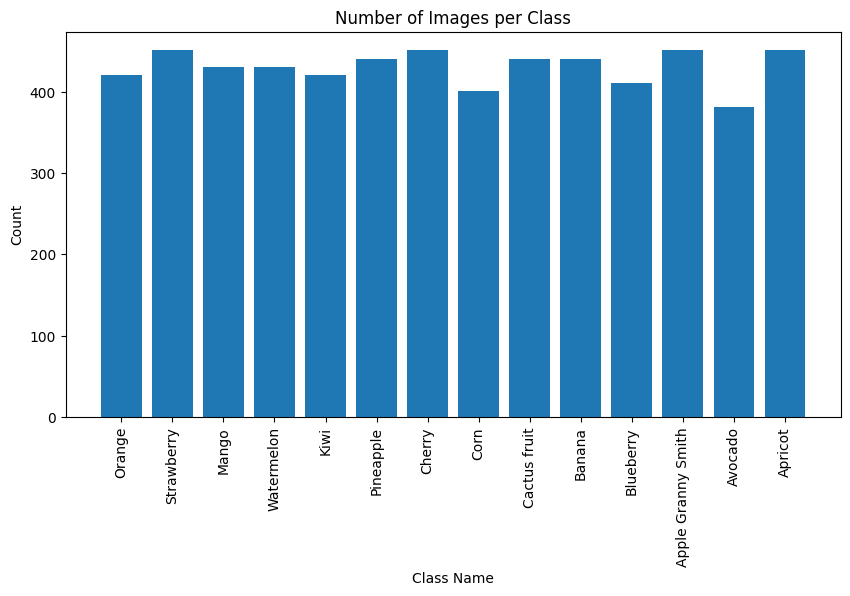

The greatest number of images for training is 451


In [ ]:
#Visualise Data distribution per class
class_counts ={}
max_images = 0
for class_name in classes_tr:
    class_path = os.path.join(path_train, class_name)

    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

        if num_images > max_images:
            max_images = num_images


#Plotting the graphic
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#The greatest number of images for training is
print(f'The greatest number of images for training is {max_images}')


Visualisation of Images per class

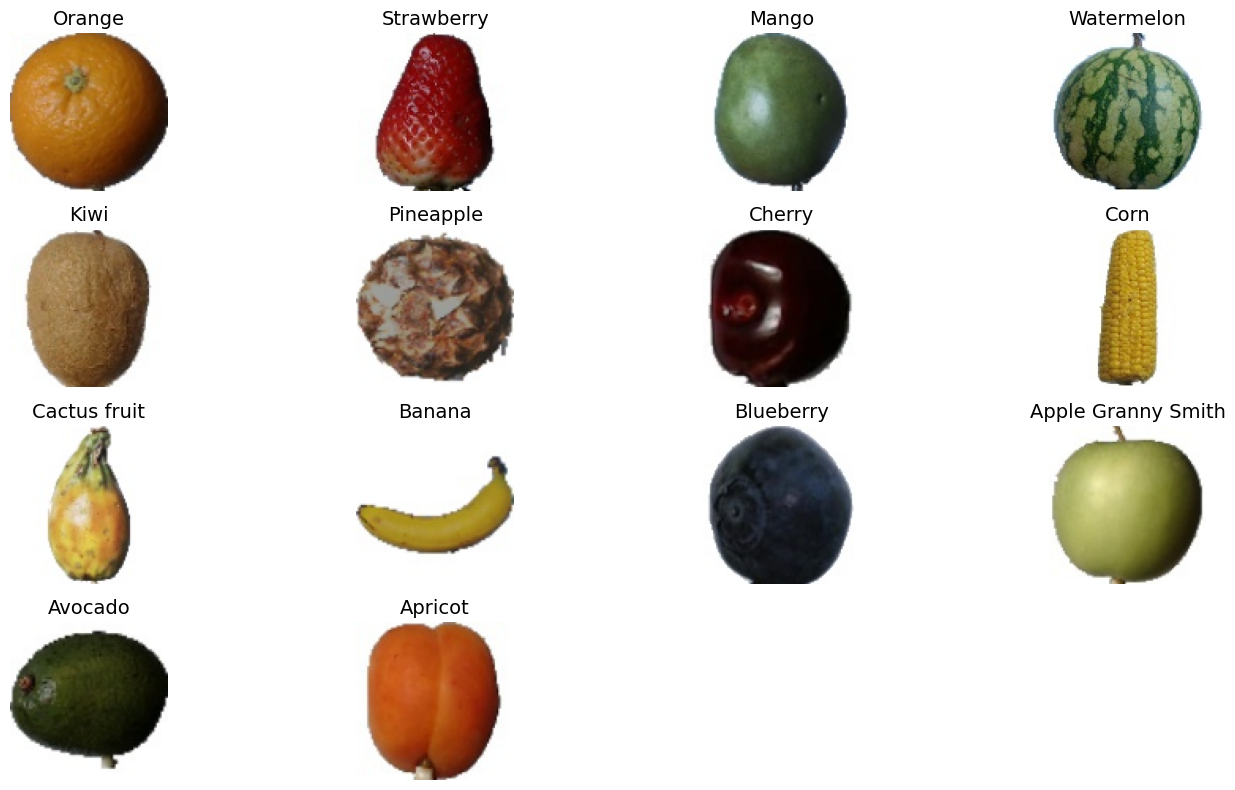

In [ ]:
def plot_samples(data_path, classes, cols=4):
    rows = math.ceil(len(classes) / cols)
    plt.figure(figsize=(14, 2 * rows))
    for i, category in enumerate(classes):
        folder = os.path.join(data_path, category)
        img_name = os.listdir(folder)[0]
        img_path = os.path.join(folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(category, fontsize=14)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(path_train, classes_tr)

<h3 style>Data Augmentation</h3>


In [ ]:
#Image dimensions and batch size
img_width, img_height = 112, 112
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

# Load training data (80%)
train_generator = datagen.flow_from_directory(
    path_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data(20%)
# same train path but using the subset 'validation'
validation_generator = datagen.flow_from_directory(
    path_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Training images: {train_generator.n}")
print(f"Validation images: {validation_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")

Found 4822 images belonging to 14 classes.
Found 1202 images belonging to 14 classes.
Training images: 4822
Validation images: 1202
Number of classes: 14


<h3>EarlyStopping</h3>

In [ ]:

# EarlyStopping: Stops the training if it does not improve after 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ReduceLROnPlateau: Reduces the learning speed if learning it gets blocked
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

def crear_modelo(learning_rate=0.001, dropout_rate=0.5):
    """
    Creates a CNN model alowing to vary hyperparameters for optimization.
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),

        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Clasificator
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),    # hyper parameter variable
        Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), # hyper parameter variable
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



<h3>Hyper parameters of the base CNN</h3>

In [10]:
# test 1: Learning Rate 0.001 (standard speed)
print("--- Training Model A (LR=0.001) ---")
model_a = crear_modelo(learning_rate=0.001)
history_a = model_a.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# test 2: Learning Rate 0.0001 (slower but more accurate)
print("\n--- Training model B (LR=0.0001) ---")
model_b = crear_modelo(learning_rate=0.0001)
history_b = model_b.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Quick comparisson
acc_a = max(history_a.history['val_accuracy'])
acc_b = max(history_b.history['val_accuracy'])
print(f"\nBest Val Accuracy Model A: {acc_a:.4f}")
print(f"Best Val Accuracy Model B: {acc_b:.4f}")

# Selecting the best model to be used
best_model = model_a if acc_a > acc_b else model_b
best_history = history_a if acc_a > acc_b else history_b
print(f"Winner model is: {'Modelo A' if acc_a > acc_b else 'Modelo B'}")

--- Training Model A (LR=0.001) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 3217s 21s/step - accuracy: 0.2196 - loss: 2.2083 - val_accuracy: 0.7762 - val_loss: 0.6313 - learning_rate: 0.0010
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7055 - loss: 0.7842 - val_accuracy: 0.9135 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8689 - loss: 0.3622 - val_accuracy: 0.9118 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9196 - loss: 0.2389 - val_accuracy: 0.9684 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9383 - loss: 0.1832 - val_accuracy: 0.9659 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9561 - loss: 0.1333 - val_accuracy: 0.9609 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9511 - loss: 

<h3>Learning Curves and Confusion Matrix</h3>

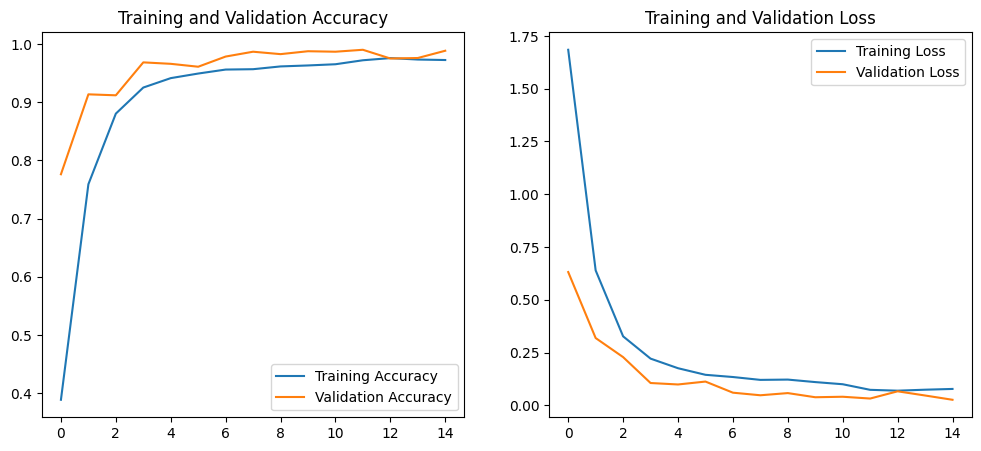

38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 866ms/step


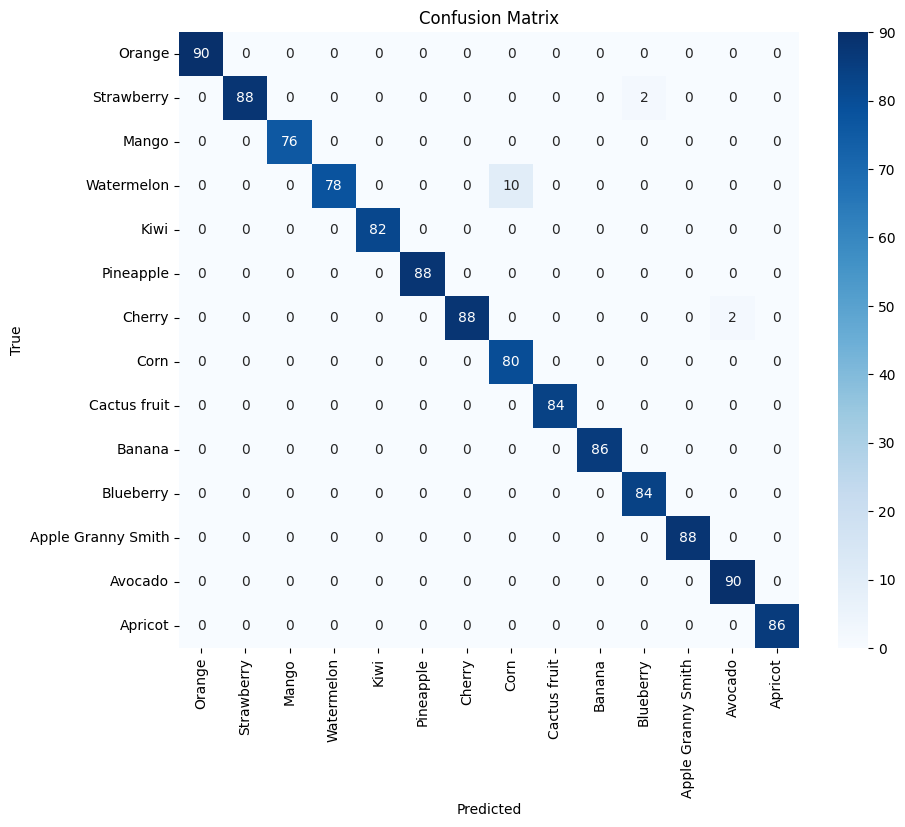

                    precision    recall  f1-score   support

            Orange       1.00      1.00      1.00        90
        Strawberry       1.00      0.98      0.99        90
             Mango       1.00      1.00      1.00        76
        Watermelon       1.00      0.89      0.94        88
              Kiwi       1.00      1.00      1.00        82
         Pineapple       1.00      1.00      1.00        88
            Cherry       1.00      0.98      0.99        90
              Corn       0.89      1.00      0.94        80
      Cactus fruit       1.00      1.00      1.00        84
            Banana       1.00      1.00      1.00        86
         Blueberry       0.98      1.00      0.99        84
Apple Granny Smith       1.00      1.00      1.00        88
           Avocado       0.98      1.00      0.99        90
           Apricot       1.00      1.00      1.00        86

          accuracy                           0.99      1202
         macro avg       0.99      0.9

In [11]:

# 1. Curvas de Aprendizaje
acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation Confusion Matrix
# Important: Reset the generator to avoid mixing the order while predicting
validation_generator.reset()
predictions = best_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_tr, yticklabels=classes_tr)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Reporte detallado
print(classification_report(y_true, y_pred, target_names=classes_tr))

<h3>Final Test</h3>

In [12]:
# creation of test generator, without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluar
print("\nEvaluating using the Test Set")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy Final: {test_acc*100:.2f}%")

Found 663 images belonging to 14 classes.

Evaluating using the Test Set


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 324s 16s/step - accuracy: 0.9957 - loss: 0.0166
Test Accuracy Final: 99.70%
